In [ ]:
import chess.pgn
from stockfish import Stockfish
import pandas as pd
import matplotlib.pyplot as plt
from move_data import MoveData

In [ ]:
class GameMove(chess.Move):
    def __init__(self, move: chess.Move, board: chess.Board, eval: dict) -> None:
        super.__init__(move)
        self.player = board.turn
        self.board = board
        if eval['type'] == 'mate':
            # Mn: white can mate in n moves; M-n: black can mate in n moves
            self.centipawn = 1000 * (1 + 1 / (eval['value'] + 1))
        else:
            self.centipawn = eval['value']
    
    def centipawnLoss(self, previousCentipawn: int):
        loss = self.centipawn - previousCentipawn
        if self.player == chess.BLACK:
            loss = -loss
        return loss
    
    def pieceMoved(self):
        return self.board.piece_at(self.to_square).symbol()

In [ ]:
df = pd.read_csv('../../dados/base/chess_games_chesscom.csv', encoding='utf-8')

In [ ]:
if 'evaluated' not in df.columns:
    df['evaluated'] = False

#### Filter the DataFrame to save memory, only keep the games from a certain player

In [ ]:
player = 'Mr-Barros'

player_games = df[df['player'] == player].reset_index()

del df

df = player_games

In [ ]:
test_pgn = df.iloc[0]['pgn']

In [ ]:
file_path = '../../dados/experimentos/'
file_name = 'Mr-Barros_vs_wtugrul_2024.10.16.pgn'

stockfish_path = 'stockfish/stockfish-windows-x86-64-avx2.exe'

params = {
    "Threads": 4,
    "Hash": 2048,
}

stockfish = Stockfish(path=stockfish_path, depth=18, parameters=params)

Experiment with:
```
stockfish.make_moves_from_current_position(["g4d7", "a8b8", "f1d1"])
```

In [ ]:
def extrai_avaliacao(pgn,numero_jogos=1, df=None, game_mask=None):
    centipawn_eval_by_piece = {}
    game_evaluations = []

    for _ in range(numero_jogos):
        game = chess.pgn.read_game(pgn)
        board = game.board()
        for move in game.mainline_moves():
            # get the evaluation for the move
            board.push(move)
            stockfish.set_fen_position(board.fen())
            eval = stockfish.get_evaluation()

            player_move = GameMove(move, eval=eval)

            

            game_evaluations.append(eval)

            piece_moved = board.piece_at(move.to_square).symbol()
            if piece_moved not in centipawn_eval_by_piece.keys():
                centipawn_eval_by_piece[piece_moved] = []
            centipawn_eval_by_piece[piece_moved].append(eval['value'])
    
    if df is not None:
        df.loc[game_mask, 'eval_by_piece'] = centipawn_eval_by_piece
        


In [ ]:
centipawn_eval_by_piece = {}
game_evaluations = []
moves: list[MoveData] = []

with open(f'{file_path}{file_name}') as pgn_file:
    game = chess.pgn.read_game(pgn_file)
    board = game.board()
    for move in game.mainline_moves():
        board.push(move)

        # Using Stockfish to get evaluation
        stockfish.set_fen_position(board.fen())
        eval = stockfish.get_evaluation()
        
        # Inserting the move as MoveData into moves
        move_data = MoveData(move, board, eval)
        moves.append(move_data)


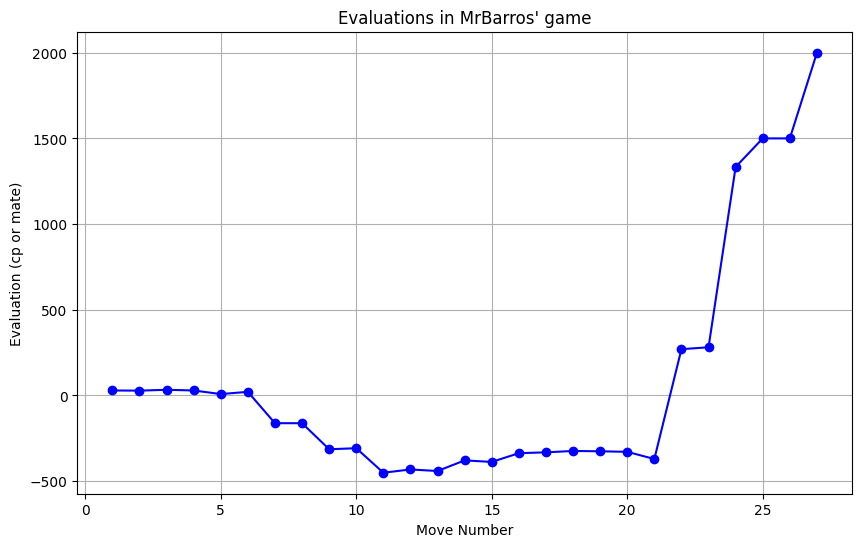

In [ ]:
eval_values = []

for move_data in moves:
    if move_data.eval['type'] == 'cp':
        eval_values.append(move_data.eval['value'])
    else:
        eval_values.append(1000 * (1 + 1 / (move_data.eval['value'] + 1)))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(moves) + 1), eval_values, marker='o', linestyle='-', color='blue')
plt.title('Evaluations in MrBarros\' game')
plt.xlabel('Move Number')
plt.ylabel('Evaluation (cp or mate)')
plt.grid(True)
plt.show()

In [15]:
features = {}

def map_eval(eval):
    if eval['type'] == 'mate':
        if eval['value'] > 0:
            return 4
        else:
            return -4
    else:
        value = eval['value']
        if value < -500:
            return -3
        elif -500 <= value < -300:
            return -2
        elif -300 <= value < -50:
            return -1
        elif -50 <= value < 50:
            return 0
        elif 50 <= value < 300:
            return 1
        elif 300 <= value < 500:
            return 2
        else:
            return 3


# Getting the 12th move or the last move
if len(moves) >= 25:
    eval = moves[24].eval
else:
    eval = moves[-1].eval

features['Opening Eval'] = map_eval(eval)


for move_data in moves:
    if move_data.white_material < 19 and move_data.black_material < 19:
        eval = move_data.eval
        features['Midgame Eval'] = map_eval(eval)

if 'Midgame Eval' not in features.keys():
    features['Midgame Eval'] = features['Opening Eval']

In [16]:
series = pd.Series(data=features)
series

Opening Eval    4
Midgame Eval    4
dtype: int64